In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import streamlit as st
import plotly.express as px

In [3]:
df=pd.read_csv("investments_VC.csv", encoding="latin-1")

**Primera fase: Exporación visual del dataset y limpieza**

In [4]:
df.columns

Index(['permalink', 'name', 'homepage_url', 'category_list', ' market ',
       ' funding_total_usd ', 'status', 'country_code', 'state_code', 'region',
       'city', 'funding_rounds', 'founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H'],
      dtype='object')

In [5]:
df_c = df.copy()

In [6]:
 # Se borran las columnas que no aportan valor y que están repetidas con otras

df_c.drop(["permalink","homepage_url","city","state_code","category_list","post_ipo_equity","post_ipo_debt","founded_month","founded_quarter","round_E","round_F","round_G","round_H"],axis=1,inplace=True)

In [7]:
df_c.columns

Index(['name', ' market ', ' funding_total_usd ', 'status', 'country_code',
       'region', 'funding_rounds', 'founded_at', 'founded_year',
       'first_funding_at', 'last_funding_at', 'seed', 'venture',
       'equity_crowdfunding', 'undisclosed', 'convertible_note',
       'debt_financing', 'angel', 'grant', 'private_equity',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D'],
      dtype='object')

In [8]:
df_c.columns = df_c.columns.str.strip()

In [9]:
df_c["funding_total_usd"] = (
    pd.to_numeric(
        df_c["funding_total_usd"]
        .astype(str)
        .str.replace(",", "", regex=False)
        .str.strip()
        .replace("-", None),
        errors="coerce"
    ).fillna(0)
)
df_c["founded_year"] = df_c["founded_year"] = pd.to_numeric(df_c["founded_year"], errors="coerce").astype("Int64")

In [10]:
df_c = df_c[df_c["name"].notna()]

In [11]:
# Para realizar un estudio más equitativo de las startups por país, voy a aplicar una reducción aleatoria de EEUU.

lista_paises = ["CAN","CHN","GBR","USA"]
df_c = df_c[df_c["country_code"].isin(lista_paises)] # El dataframe ahora van a ser todos los paises que sen >1000 empresas, osea los de la lista

filas_no_eeuu = df_c[df_c["country_code"] != "USA"] # Solo NO USA

filas_eeuu = df_c[df_c["country_code"]=="USA"].sample(n = 2600,random_state = 42) # Solo USA

df_c = pd.concat([filas_no_eeuu,filas_eeuu],ignore_index=True) # Nuevo df



In [12]:
numeros_mayores = df_c.groupby("country_code")["name"].count().loc[lambda x: x > 1000]
numeros_mayores

country_code
CAN    1405
CHN    1239
GBR    2642
USA    2600
Name: name, dtype: int64

In [13]:
df_c["status"] = df_c["status"].apply([lambda x: "fail" if x == "closed" else "success"]) # Se agrupan de forma indirecta  adquirida y operativa como "saccess"


-------------

<h3>Como se ve la distribución de startups

In [14]:

data = {
    "pais": [
        "USA", "USA", "USA", "USA", "USA",
        "CHINA", "CHINA", "CHINA",
        "GBR", "GBR", "GBR",
        "CAN", "CAN", "CAN"
    ],
    "ciudad": [
        "New York City", "Chicago", "Boston", "SF Bay Area", "Seattle",
        "Beijing", "Shanghai", "Guangzhou",
        "Manchester", "London", "Bath",
        "Ottawa", "Toronto", "Vancouver"
    ],
    "lat": [
        40.71427, 41.881832, 42.361145, 37.828724, 47.608013,
        39.916668, 31.224361, 23.128994,
        53.483959, 51.509865, 51.380001,
        45.424721, 43.651070, 49.246292
    ],
    "lon": [
        -74.00597, -87.623177, -71.057083, -122.355537, -122.335167,
        116.383331, 121.469170, 113.253250,
        -2.244644, -0.118092, -2.360000,
        -75.695000, -79.347015, -123.116226
    ]
}

df_ciudades = pd.DataFrame(data)



In [15]:

def grafico_ciudades (df_c):
    fig = px.scatter_mapbox(
        df_ciudades,
        lat="lat",
        lon="lon",
        hover_name="ciudad",
        hover_data=["pais"],
        color="pais",           # Colorea por país
        size_max=80,            # Tamaño máximo de los puntos
        zoom=1,               # Nivel de zoom inicial (1 = vista global)
        height=400
    )

    fig.update_layout(
        mapbox_style="open-street-map",   # Mapa limpio y profesional
        margin={"r":0,"t":0,"l":0,"b":0}
    )

    return fig  # <--- muestra el mapa (en notebook o script)


------------

<h3>Principales mercados por país: TOP 5</h3>

In [16]:
mrk_usa = df_c[df_c["country_code"]=="USA"]["market"].value_counts()
mrk_usa.head(10)  


market
Software                288
Biotechnology           264
Mobile                   90
Health Care              89
Enterprise Software      84
Curated Web              79
E-Commerce               70
Hardware + Software      65
Health and Wellness      63
Advertising              61
Name: count, dtype: int64

In [17]:
mrk_can = df_c[df_c["country_code"]=="CAN"]["market"].value_counts()
can_top_10 = mrk_can.head(5) 

In [18]:
mrk_chn = df_c[df_c["country_code"]=="CHN"]["market"].value_counts()
chn_top_10 = mrk_chn.head(5) 

In [19]:
mrk_gbr = df_c[df_c["country_code"]=="GBR"]["market"].value_counts()
gbr_top_10 = mrk_gbr.head(5) 

----------------

<h3> Qué sector por país tiende mayor tasa de éxito ?

In [20]:
top_sec = df_c.groupby("country_code")["status"].value_counts().groupby(level=0,).head(5)

top_sec = top_sec.reset_index(name="count")
top_sec

,country_code,status,count
0,CAN,success,1339
1,CAN,fail,66
2,CHN,success,1203
3,CHN,fail,36
4,GBR,success,2486
5,GBR,fail,156
6,USA,success,2460
7,USA,fail,140


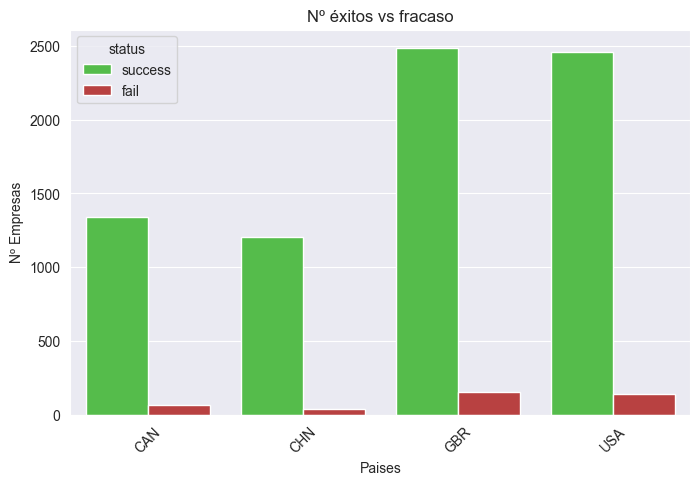

In [21]:
sns.set_style("darkgrid")
plt.figure(figsize = (8,5))
sns.barplot(data = top_sec,
            x="country_code",
            y="count",
            hue="status",
            palette={"success":"#45CF38","fail":"#CC2D2D"})
plt.title("Nº éxitos vs fracaso")
plt.xlabel("Paises")
plt.ylabel("Nº Empresas")
plt.xticks(rotation = 45)
plt.show()

--------

<h3>¿Mayor fuerza de inversión pública o privada? (Mill $)

In [48]:
round(df_c.groupby("country_code")[["angel","grant"]].sum()/1e6,2)

,angel,grant
country_code,,
CAN,112.20,38.23
CHN,352.51,0.33
GBR,171.70,777.55
USA,134.20,393.48


Podemos observar que Canadá y China tienen mayor inversión por parte de entes privados, 
    
mientyras que EEUU y Gran Bretaña, tienen mayor inversión mediante subvenciones subvenciones

In [23]:
df_pp = round(df_c.groupby("country_code")[["angel","grant"]].sum()/1e6,2) # Paso el resultado a millones

df_plot = df_pp.reset_index().melt(id_vars = "country_code",
                                    var_name = "Tipo de inversión",    # Creo el dataframe para poder pintar la gráfica
                                    value_name = "Millones USD")     

fig = px.bar(
    df_plot,
    x="country_code",
    y="Millones USD",
    color="Tipo de inversión",
    color_discrete_map={
        "angel": "#38C2CF",  # verde
        "grant": "#1D42C5"   # rojo
    },
    title="Inversiones por país (Millones $)",
    width=600,
    height=400
)
fig.show()


------------

<h3> ¿Importa la cantidad inicialmente aportada por un "angel" o "seed" para tener éxito?

In [24]:
df_sa = df_c[["name","status","market","funding_total_usd"]].copy()
df_sa["sum_a_s"] = df_c["angel"] + df_c["seed"]
df_sa

,name,status,market,funding_total_usd,sum_a_s
0,(In)Touch Network,success,Electronics,1500000.0,1500000.0
1,10 Minutes With,success,Education,4400000.0,400000.0
2,1006.tv,success,Media,10000000.0,0.0
3,100e.com,success,Education,4500000.0,0.0
4,10°North,success,Fashion,0.0,0.0
...,...,...,...,...,...
7881,Lionseek,success,Advertising,0.0,0.0
7882,BuildMyMove,fail,NaN,1500000.0,0.0
7883,NERITES,fail,Biotechnology,2269779.0,0.0
7884,imoji,success,Mobile,2000000.0,0.0


In [25]:
# Como son tipos de datos diferentes y los casos diferentes de la categórica son 2, aplico t-student

conteo_s = df_sa[df_sa["status"] == "success"]["sum_a_s"]
conteo_f = df_sa[df_sa["status"] == "fail"]["sum_a_s"]

# Antes de realizar el contraste fijamos un 0.05 como tasa de error
t_stat,p_valor = stats.ttest_ind(conteo_f,conteo_s,equal_var= True)
print(f"El t_stat es: {t_stat}, y el p_valor es: {p_valor}")

El t_stat es: -1.3677665510761403, y el p_valor es: 0.17142414575908563


**CONCLUSIONES**

- Al tener un valor de t negativo, nos indica que el primer grupo, es decir, success (conteo_f) tienen una media mayor con respect al primer grupo.

- En cuento al valor de p-valor, al ser mayor que nuestro límite inicial 0.05, podemos decir que no existe un evidencia clara de que por 
invertir más en una empresa,en su etapa inicial, tenga mayor probabilidad de ser éxito.

In [26]:
conteo_s = df_sa[df_sa["status"] == "success"]["funding_total_usd"]
conteo_f = df_sa[df_sa["status"] == "fail"]["funding_total_usd"]

# Antes de realizar el contraste fijamos un 0.05 como tasa de error
t_stat,p_valor = stats.ttest_ind(conteo_f,conteo_s,equal_var= True)
print(f"El t_stat es: {t_stat}, y el p_valor es: {p_valor}")

El t_stat es: -2.6640593612072907, y el p_valor es: 0.0077360997781323396


**CONCLUSIONES**



--------

Existe algún sector en que haya mayor tasa de éxito? Cual es la media que se invierte en ese sector? 

Y en que punto geográfico se sitúa la mayor aglomeración con más éxito dentro del propio sector?

In [27]:
top_5_e = df_c[df_c["status"] == "success"].groupby("market")["status"].count().sort_values(ascending = False).head(5) #se encuentran los sectores con más numero de empresas exitosas
top_5_m = top_5_e.index

In [28]:
df_top5 = df_c[(df_c["market"].isin(top_5_m)) & (df_c["status"] == "success")]


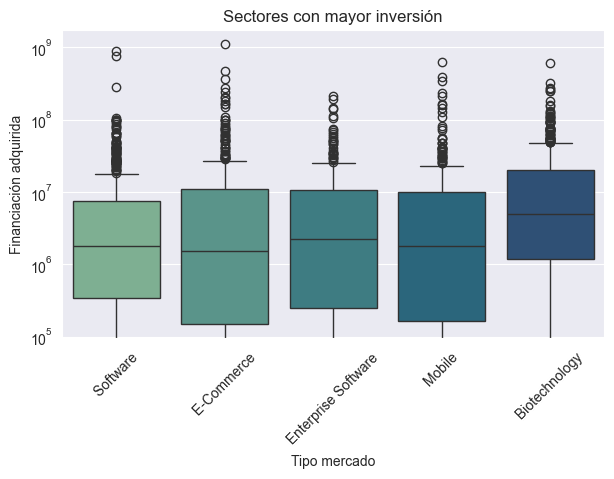

In [29]:

plt.figure(figsize=(7,4))
sns.boxplot(df_top5,x = "market", y = "funding_total_usd", palette = "crest", hue= "market", legend = False)

plt.yscale("log")     # Se usa el loraritmo ya que existe una gran variedad de financiaciones que pueden varian mucho.

plt.title("Sectores con mayor inversión")
plt.xlabel("Tipo mercado")
plt.ylabel("Financiación adquirida")
plt.xticks(rotation=45)
plt.show()

**OBSERVACIONES**

Ha simple vista podemos ver que que los sectores de e-commerce y Mobile, son los que presentan mayor variación y el de Biotecnología tiende a tener inversiones medias más altas.

In [30]:
biotx = df_c[(df_c["market"]==" Biotechnology ") & (df_c["status"]=="success")].groupby("country_code")["status"].count().sort_values(ascending= False)

In [31]:
biotx_df = biotx.reset_index() # convierto las serie biotx en df
biotx_df.columns = ['country_code','count']

#  gráfica de pastel
fig = px.pie(
    biotx_df, 
    names='country_code',             
    values='count',                 
    title='Startups exitosas en Biotecnología por país',
    width= 500,
    height= 400,
    color_discrete_sequence=px.colors.diverging.RdBu_r
    
)
fig.update_traces(textinfo='percent+label', pull=[0.05, 0.05, 0.05, 0.05])

fig.show()

**CONCLUSIONES**

Se puede apreciar que EEUU es la principal acogedora de startups del sector Biotech.

----------

<h3> Hay muchas empresas que nacieron y pasado un tiempo quisieron crecer y pidieron una financiación. 

Existe alguna relación entre haber "rodado" antes y ser exitoso?

In [32]:
df_c["founded_at"]= df_c["founded_at"].fillna(df_c["first_funding_at"]) # Se rellenan los valores nulos de "fundado en" por la fecha que pone como "primera financiación"

In [33]:
df_c["first_fund_year"] = pd.to_datetime(df_c["first_funding_at"]).dt.year # Se transforma a fecha la columna

In [34]:
df_c["founded_at"] = pd.to_datetime(df_c["founded_at"]) # Paso a formato fecha la columna founded_at
df_c["founded_year"] = df_c["founded_year"].fillna(df_c["founded_at"].dt.year) # relleno los valores nulos con el año de founded_at 

In [35]:
df_c["years_between"] = df_c["first_fund_year"] - df_c["founded_year"] # Se ve la diferencia de años

In [36]:
df_c.groupby("status")["years_between"].mean()

status
fail       1.756281
success    2.971287
Name: years_between, dtype: Float64

In [37]:
media_f = df_c[df_c["status"]=="fail"]["years_between"]
media_s = df_c[df_c["status"]=="success"]["years_between"]

# al realizar el test se asume un error del 0.05
t_start,p_value = stats.ttest_ind(media_f,media_s,equal_var= True)
print(f"El t_start es: {t_start}, y su p_valor es: {p_value}")

El t_start es: -3.5402886045719257, y su p_valor es: 0.00040199508271318313


**CONCLUSIONES**

Se observa que el efecto "rodaje" de una empresa antes de ser financiada, **SI** que tiene relevancia para determinar si puede tener éxito o no.

--------------

<h3> El número de ronda de financiación guarda algún tipo de relción con la supervivencia de la startup ??

In [38]:
df_c["funding_rounds"] = (df_c[["round_A","round_B","round_C"]] > 0).sum(axis=1)

In [39]:
df_c.groupby(["funding_rounds","status"])["status"].count()

funding_rounds  status 
0               fail        297
                success    5425
1               fail         81
                success    1441
2               fail         17
                success     447
3               fail          3
                success     175
Name: status, dtype: int64

In [40]:
df_c.groupby(["funding_rounds","status"])["funding_total_usd"].mean()

funding_rounds  status 
0               fail       2.600512e+06
                success    9.191119e+06
1               fail       1.216411e+07
                success    1.675503e+07
2               fail       1.711839e+07
                success    3.657734e+07
3               fail       4.551823e+07
                success    1.007410e+08
Name: funding_total_usd, dtype: float64

In [41]:
df_counts = df_c.groupby(["funding_rounds", "status"])["status"].count().reset_index(name="count")

# Pivot para tener status como columnas
df_pivot = df_counts.pivot(index="funding_rounds", columns="status", values="count").fillna(0)

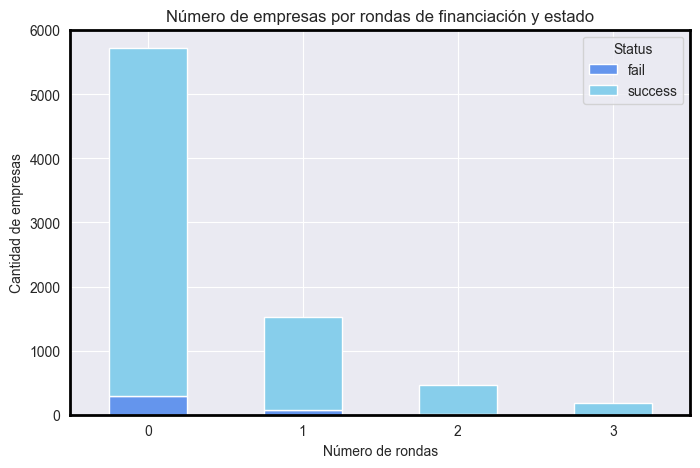

In [42]:
fig, ax = plt.subplots(figsize=(8,5))

df_pivot.plot(
    kind="bar", 
    stacked=True, 
    ax=ax, 
    color=["cornflowerblue","skyblue"]
)
ax.set_title("Número de empresas por rondas de financiación y estado")
ax.set_xlabel("Número de rondas")
ax.set_ylabel("Cantidad de empresas")

ax.legend(title="Status")
plt.xticks(rotation=0)

for spine in ax.spines.values():
    spine.set_color('black')   
    spine.set_linewidth(2)     


In [43]:
df_c.to_csv("df_startup.csv", index=False)